# This notebook runs YAW on the full sample

now a few things we can test: 

- Angular scale
- theta weighting
- number of jk

to see if SNR can be improved

In [1]:
import pylab as pl
import healpy as hp
from astropy.io import fits
import numpy as np

import os
import shutil

from yaw import Catalog, Configuration, RedshiftData, autocorrelate, crosscorrelate
from yaw.correlation.measurements import autocorrelate_scalar,  crosscorrelate_scalar
# but need to add it in the __init__
from yaw.utils.logging import get_logger
from yaw.utils import parallel

In [2]:
import yaw

In [3]:
from yaw.options import Unit

In [4]:
root = "/pscratch/sd/q/qhang/desi-lya/yaw/"

In [7]:
zsampf = np.loadtxt('/pscratch/sd/q/qhang/desi-lya/delta_F/zbins.txt')
edges = zsampf[:,0]
zsamp = zsampf[:-1,1]

In [9]:
bias_z = np.loadtxt("bias_dc2.txt")

bias_z_int = np.interp(zsamp, bias_z[:,0], bias_z[:,1])

In [24]:
nz_true = np.loadtxt("nz_phot_samp-zbin-match.txt")

The code is in `measure_yaw.py`. Sample is run with the DESI x LSST joint footprint.

### n(z) true

In [5]:
# load redshift distribution and save:
zsampf = np.loadtxt('/pscratch/sd/q/qhang/desi-lya/delta_F/zbins.txt')
edges = zsampf[:,0]
zsamp = zsampf[:-1,1]

fname = "/pscratch/sd/q/qhang/desi-lya/photometry-catalogue-overlap-zmin-1.8.fits"
fin=fits.open(fname)
z=fin[1].data['Z']

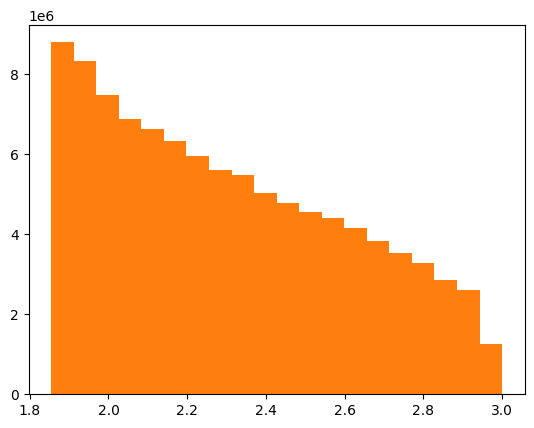

In [7]:
cc=pl.hist(z, bins=100, range=[edges[0],edges[1]])
x = (cc[1][1:] + cc[1][:-1] )/2.
np.savetxt("nz_phot_samp.txt",np.c_[x,cc[0]])


cc=pl.hist(z, bins=edges)
x = (cc[1][1:] + cc[1][:-1] )/2.
np.savetxt("nz_phot_samp-zbin-match.txt",np.c_[x,cc[0]])

### Fiducial case:
- NJN = 64
- no theta weights
- theta range is [1,20] arcmin

Show cross-correlation data with error, auto-correlation and cross-correlation measurements, correlation matrix

In [58]:
# load data here:
folder = "test-njn-64-noscale-1-20-arcm/"
ncc = RedshiftData.from_files(root + folder + "nz_estimate")
#ncc.data, ncc.error
w_sp = yaw.correlation.corrfunc.CorrFunc_scalar.from_file(root + folder +  "w_sp.hdf5")
w_ss = yaw.correlation.corrfunc.CorrFunc_scalar.from_file(root + folder +  "w_ss.hdf5")

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:607: RuntimeWarning: invalid value encountered in divide
  data = counts.data / sum_weights.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:608: RuntimeWarning: invalid value encountered in divide
  samples = counts.samples / sum_weights.samples


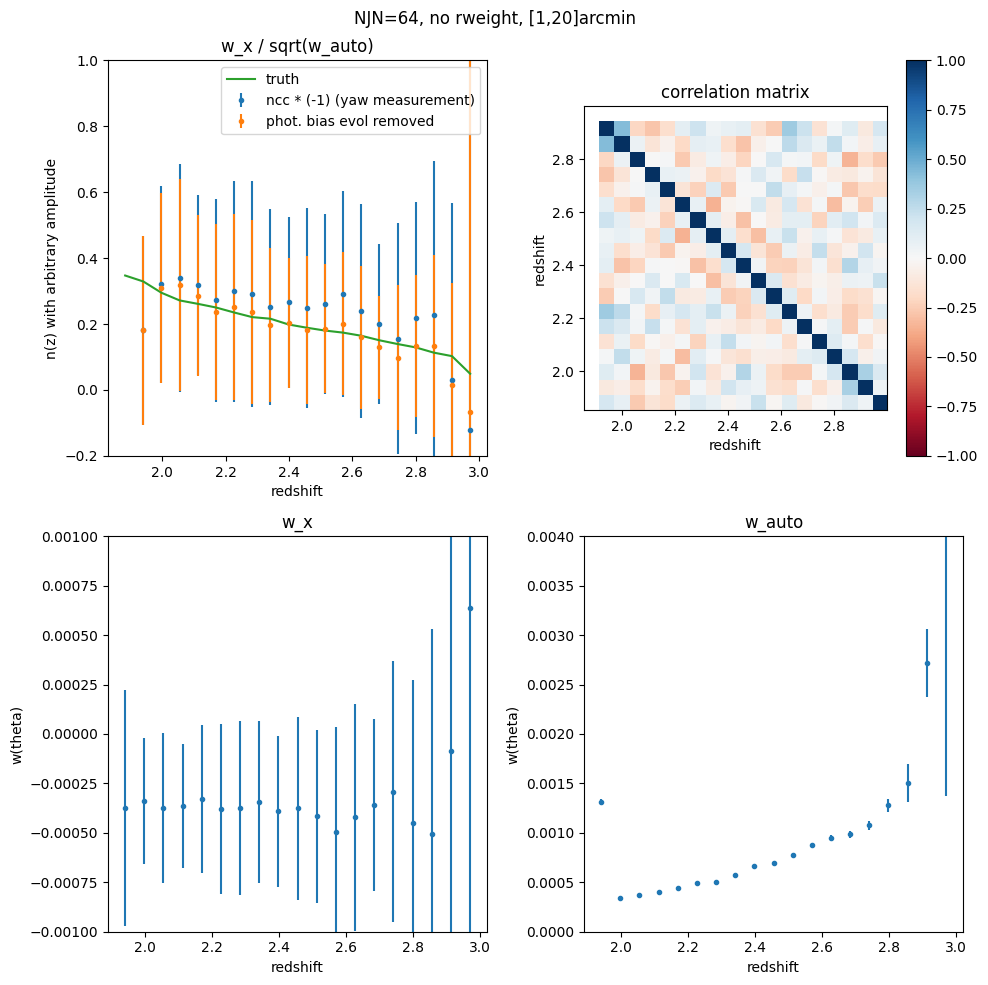

In [43]:
fig,axarr=pl.subplots(2,2, figsize=[10,10])
fig.suptitle("NJN=64, no rweight, [1,20]arcmin")
x = ncc.binning.mids

pl.sca(axarr[0,0])
pl.errorbar(x, -ncc.data, yerr=ncc.error,fmt='.',label="ncc * (-1) (yaw measurement)")
pl.ylabel("n(z) with arbitrary amplitude")
pl.xlabel("redshift")
pl.title("w_x / sqrt(w_auto)")
pl.errorbar(x, -ncc.data/bias_z_int*bias_z_int[1], 
            yerr=ncc.error/bias_z_int*bias_z_int[1],fmt='.',label="phot. bias evol removed")
pl.ylim([-0.2,1.0])
factor=0.23
pl.plot(nz_true[:,0], nz_true[:,1]/np.sum(nz_true[:,1])/(nz_true[1,0]-nz_true[0,0])*factor,label="truth")
pl.legend()

pl.sca(axarr[0,1])
pl.imshow(ncc.correlation,vmax=1,vmin=-1,cmap='RdBu',extent=[edges[0],edges[-1], edges[0],edges[-1]])
pl.colorbar()
pl.xlabel("redshift")
pl.ylabel("redshift")
pl.title("correlation matrix")

pl.sca(axarr[1,0])
w_sp_samp = w_sp.sample()  # creates a CorrFunc object
pl.errorbar(x, w_sp_samp.data, yerr=w_sp_samp.error,fmt='.')
pl.ylabel("w(theta)")
pl.xlabel("redshift")
pl.title("w_x")
pl.ylim([-0.001,0.001])

pl.sca(axarr[1,1])
w_ss_samp = w_ss.sample()  # creates a CorrFunc object
pl.errorbar(x, w_ss_samp.data, yerr=w_ss_samp.error,fmt='.')
pl.ylabel("w(theta)")
pl.xlabel("redshift")
pl.title("w_auto")
pl.ylim([0,0.004])
pl.tight_layout()

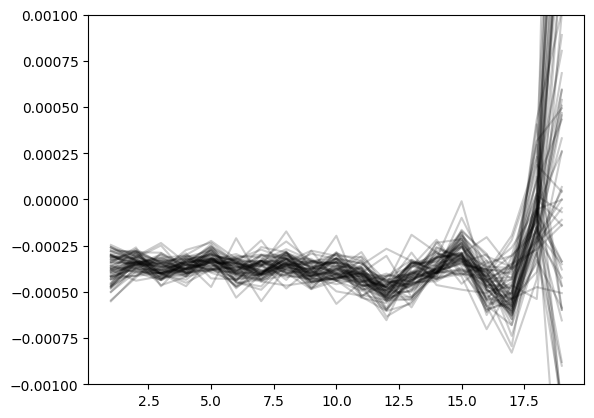

In [17]:
for ii in range(64):
    pl.plot(w_sp_samp.samples[ii,:], color='k',alpha=0.2)
    pl.ylim([-0.001,0.001])

# Varying number of jackknife, theta weights, and theta ranges

In [44]:
# load data here:
folder = "test-njn-128-noscale-1-20-arcm/"
ncc = RedshiftData.from_files(root + folder + "nz_estimate")
#ncc.data, ncc.error
w_sp = yaw.correlation.corrfunc.CorrFunc_scalar.from_file(root + folder +  "w_sp.hdf5")
w_ss = yaw.correlation.corrfunc.CorrFunc_scalar.from_file(root + folder +  "w_ss.hdf5")

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:607: RuntimeWarning: invalid value encountered in divide
  data = counts.data / sum_weights.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:608: RuntimeWarning: invalid value encountered in divide
  samples = counts.samples / sum_weights.samples


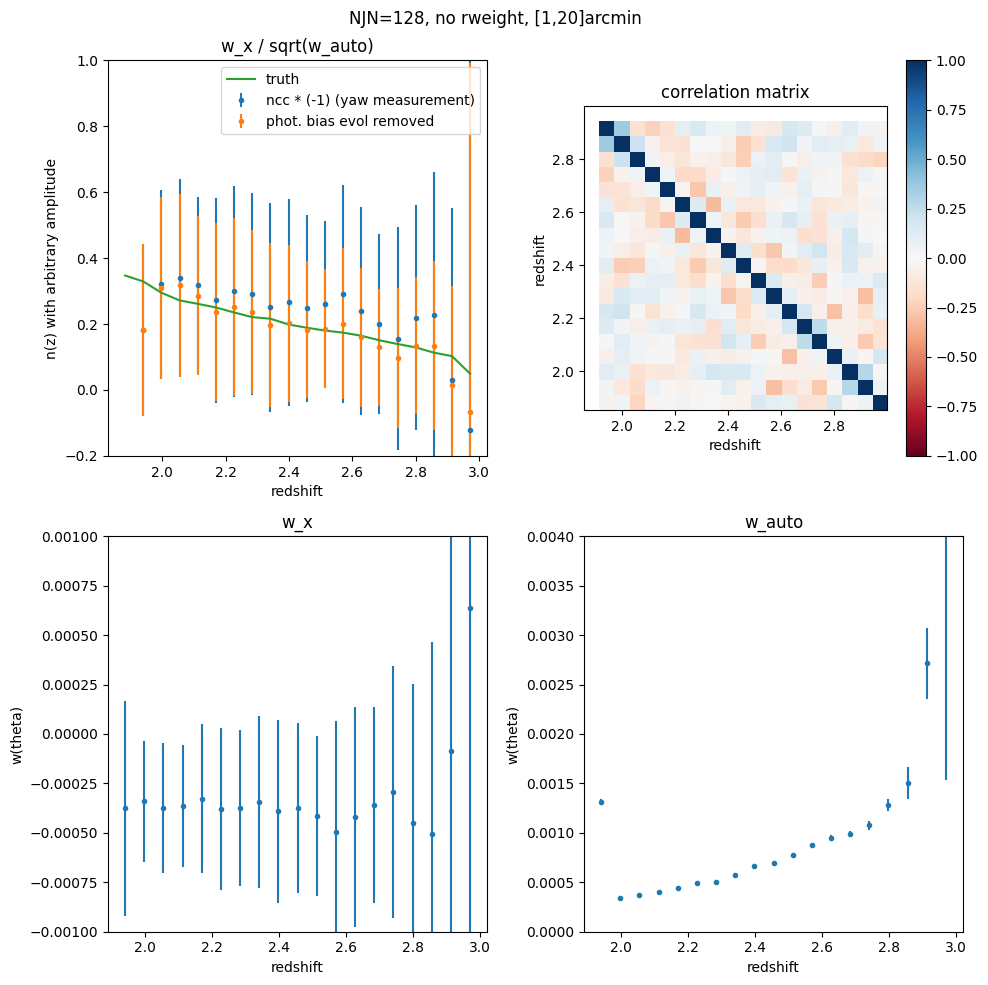

In [45]:
fig,axarr=pl.subplots(2,2, figsize=[10,10])
fig.suptitle("NJN=128, no rweight, [1,20]arcmin")
x = ncc.binning.mids

pl.sca(axarr[0,0])
pl.errorbar(x, -ncc.data, yerr=ncc.error,fmt='.',label="ncc * (-1) (yaw measurement)")
pl.ylabel("n(z) with arbitrary amplitude")
pl.xlabel("redshift")
pl.title("w_x / sqrt(w_auto)")
pl.errorbar(x, -ncc.data/bias_z_int*bias_z_int[1], 
            yerr=ncc.error/bias_z_int*bias_z_int[1],fmt='.',label="phot. bias evol removed")
pl.ylim([-0.2,1.0])
factor=0.23
pl.plot(nz_true[:,0], nz_true[:,1]/np.sum(nz_true[:,1])/(nz_true[1,0]-nz_true[0,0])*factor,label="truth")
pl.legend()

pl.sca(axarr[0,1])
pl.imshow(ncc.correlation,vmax=1,vmin=-1,cmap='RdBu',extent=[edges[0],edges[-1], edges[0],edges[-1]])
pl.colorbar()
pl.xlabel("redshift")
pl.ylabel("redshift")
pl.title("correlation matrix")

pl.sca(axarr[1,0])
w_sp_samp = w_sp.sample()  # creates a CorrFunc object
pl.errorbar(x, w_sp_samp.data, yerr=w_sp_samp.error,fmt='.')
pl.ylabel("w(theta)")
pl.xlabel("redshift")
pl.title("w_x")
pl.ylim([-0.001,0.001])

pl.sca(axarr[1,1])
w_ss_samp = w_ss.sample()  # creates a CorrFunc object
pl.errorbar(x, w_ss_samp.data, yerr=w_ss_samp.error,fmt='.')
pl.ylabel("w(theta)")
pl.xlabel("redshift")
pl.title("w_auto")
pl.ylim([0,0.004])
pl.tight_layout()

In [46]:
# load data here:
folder = "test-njn-64-scale-1-20-arcm/"
ncc = RedshiftData.from_files(root + folder + "nz_estimate")
#ncc.data, ncc.error
w_sp = yaw.correlation.corrfunc.CorrFunc_scalar.from_file(root + folder +  "w_sp.hdf5")
w_ss = yaw.correlation.corrfunc.CorrFunc_scalar.from_file(root + folder +  "w_ss.hdf5")

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:607: RuntimeWarning: invalid value encountered in divide
  data = counts.data / sum_weights.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:608: RuntimeWarning: invalid value encountered in divide
  samples = counts.samples / sum_weights.samples


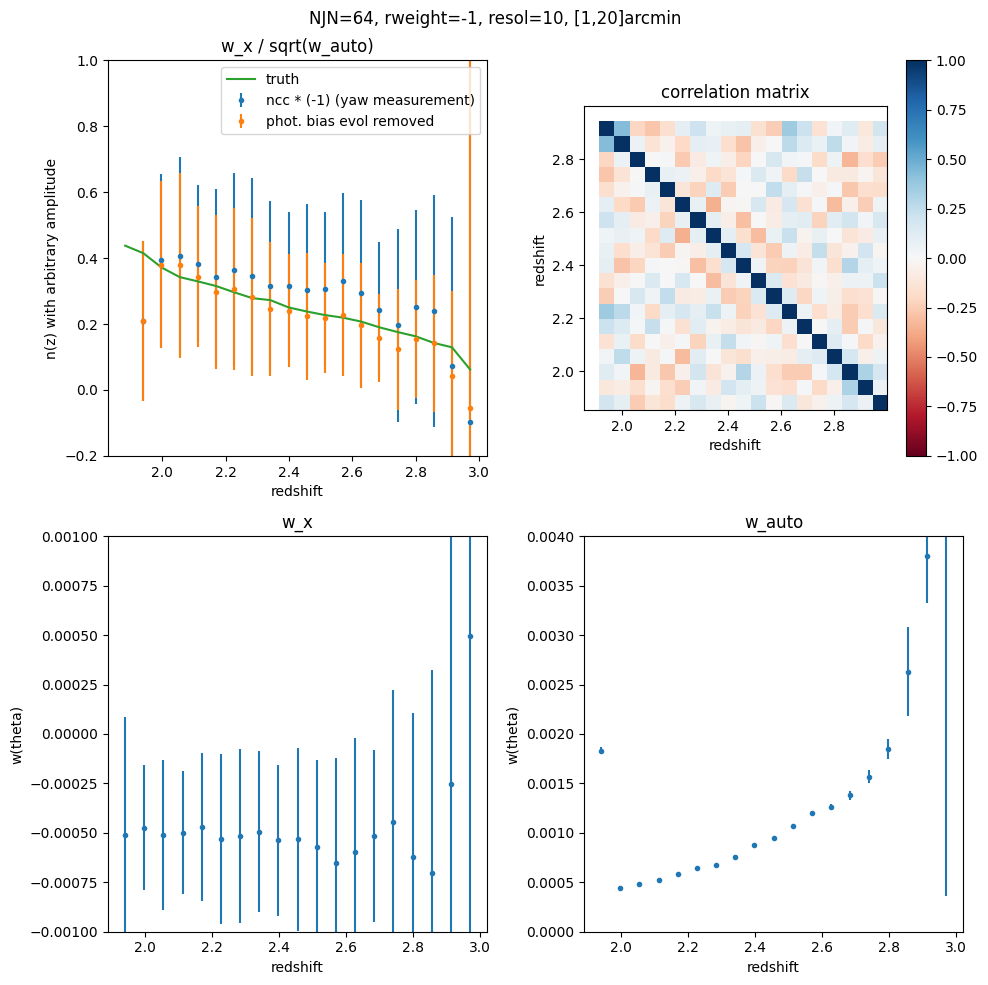

In [50]:
fig,axarr=pl.subplots(2,2, figsize=[10,10])
fig.suptitle("NJN=64, rweight=-1, resol=10, [1,20]arcmin")
x = ncc.binning.mids

pl.sca(axarr[0,0])
pl.errorbar(x, -ncc.data, yerr=ncc.error,fmt='.',label="ncc * (-1) (yaw measurement)")
pl.ylabel("n(z) with arbitrary amplitude")
pl.xlabel("redshift")
pl.title("w_x / sqrt(w_auto)")
pl.errorbar(x, -ncc.data/bias_z_int*bias_z_int[1], 
            yerr=ncc.error/bias_z_int*bias_z_int[1],fmt='.',label="phot. bias evol removed")
pl.ylim([-0.2,1.0])
factor=0.29
pl.plot(nz_true[:,0], nz_true[:,1]/np.sum(nz_true[:,1])/(nz_true[1,0]-nz_true[0,0])*factor,label="truth")
pl.legend()

pl.sca(axarr[0,1])
pl.imshow(ncc.correlation,vmax=1,vmin=-1,cmap='RdBu',extent=[edges[0],edges[-1], edges[0],edges[-1]])
pl.colorbar()
pl.xlabel("redshift")
pl.ylabel("redshift")
pl.title("correlation matrix")

pl.sca(axarr[1,0])
w_sp_samp = w_sp.sample()  # creates a CorrFunc object
pl.errorbar(x, w_sp_samp.data, yerr=w_sp_samp.error,fmt='.')
pl.ylabel("w(theta)")
pl.xlabel("redshift")
pl.title("w_x")
pl.ylim([-0.001,0.001])

pl.sca(axarr[1,1])
w_ss_samp = w_ss.sample()  # creates a CorrFunc object
pl.errorbar(x, w_ss_samp.data, yerr=w_ss_samp.error,fmt='.')
pl.ylabel("w(theta)")
pl.xlabel("redshift")
pl.title("w_auto")
pl.ylim([0,0.004])
pl.tight_layout()

In [51]:
# load data here:
folder = "test-njn-64-noscale-1-10-arcm/"
ncc = RedshiftData.from_files(root + folder + "nz_estimate")
#ncc.data, ncc.error
w_sp = yaw.correlation.corrfunc.CorrFunc_scalar.from_file(root + folder +  "w_sp.hdf5")
w_ss = yaw.correlation.corrfunc.CorrFunc_scalar.from_file(root + folder +  "w_ss.hdf5")

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:607: RuntimeWarning: invalid value encountered in divide
  data = counts.data / sum_weights.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:608: RuntimeWarning: invalid value encountered in divide
  samples = counts.samples / sum_weights.samples


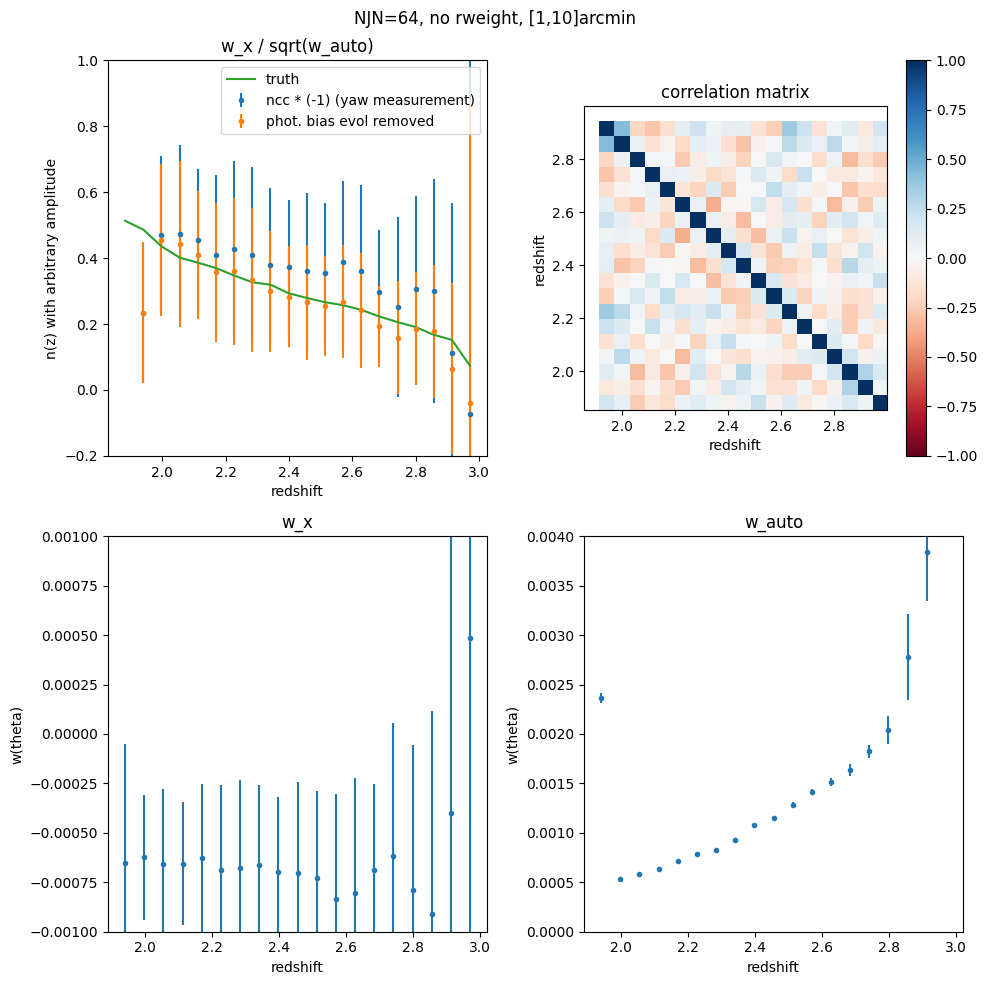

In [55]:
fig,axarr=pl.subplots(2,2, figsize=[10,10])
fig.suptitle("NJN=64, no rweight, [1,10]arcmin")
x = ncc.binning.mids

pl.sca(axarr[0,0])
pl.errorbar(x, -ncc.data, yerr=ncc.error,fmt='.',label="ncc * (-1) (yaw measurement)")
pl.ylabel("n(z) with arbitrary amplitude")
pl.xlabel("redshift")
pl.title("w_x / sqrt(w_auto)")
pl.errorbar(x, -ncc.data/bias_z_int*bias_z_int[1], 
            yerr=ncc.error/bias_z_int*bias_z_int[1],fmt='.',label="phot. bias evol removed")
pl.ylim([-0.2,1.0])
factor=0.34
pl.plot(nz_true[:,0], nz_true[:,1]/np.sum(nz_true[:,1])/(nz_true[1,0]-nz_true[0,0])*factor,label="truth")
pl.legend()

pl.sca(axarr[0,1])
pl.imshow(ncc.correlation,vmax=1,vmin=-1,cmap='RdBu',extent=[edges[0],edges[-1], edges[0],edges[-1]])
pl.colorbar()
pl.xlabel("redshift")
pl.ylabel("redshift")
pl.title("correlation matrix")

pl.sca(axarr[1,0])
w_sp_samp = w_sp.sample()  # creates a CorrFunc object
pl.errorbar(x, w_sp_samp.data, yerr=w_sp_samp.error,fmt='.')
pl.ylabel("w(theta)")
pl.xlabel("redshift")
pl.title("w_x")
pl.ylim([-0.001,0.001])

pl.sca(axarr[1,1])
w_ss_samp = w_ss.sample()  # creates a CorrFunc object
pl.errorbar(x, w_ss_samp.data, yerr=w_ss_samp.error,fmt='.')
pl.ylabel("w(theta)")
pl.xlabel("redshift")
pl.title("w_auto")
pl.ylim([0,0.004])
pl.tight_layout()

# Validation with treecorr with the big catalogue

Codes are in `measure_yaw-treecorr-ver.py`

In [69]:
folder = "test-njn-64-noscale-1-20-arcm/"
nkres = np.loadtxt(root + folder + "treecorr_nk.txt")
kkres = np.loadtxt(root + folder + "treecorr_kk.txt")
nccres = np.loadtxt(root + folder + "treecorr_ncc.txt")

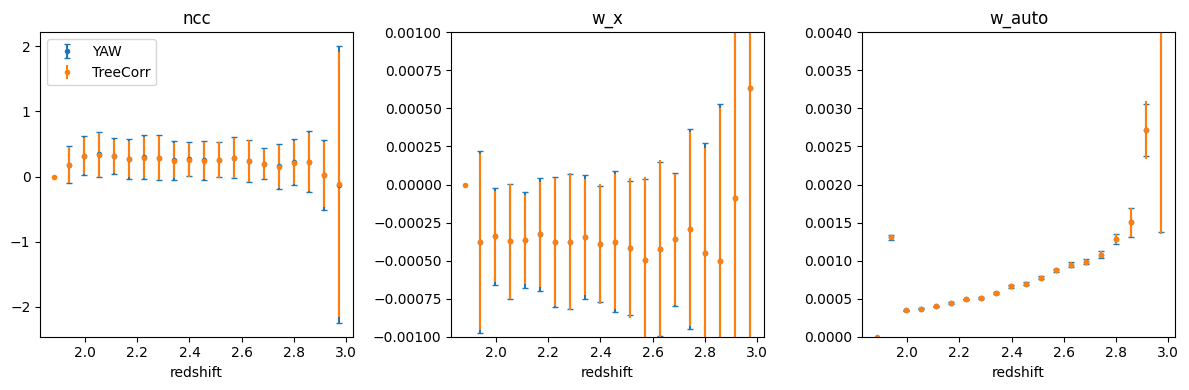

In [86]:
# compare mean and errorbar:

fig,axarr=pl.subplots(1,3,figsize=[12,4])
pl.sca(axarr[0])
factor = 17
pl.errorbar(x, -ncc.data, yerr=ncc.error,fmt='.',label="YAW", capsize=2)
pl.errorbar(zsamp, -nccres[:,0]*factor, yerr=nccres[:,1]*factor, fmt='.',label="TreeCorr")
pl.legend()
pl.title("ncc")
pl.xlabel("redshift")
pl.sca(axarr[1])
w_sp_samp = w_sp.sample()  # creates a CorrFunc object
pl.errorbar(zsamp, w_sp_samp.data, yerr=w_sp_samp.error,fmt='.', capsize=2)
pl.errorbar(zsamp, nkres[:,0], yerr=nkres[:,1], fmt='.')
pl.ylim([-0.001,0.001])
pl.title("w_x")
pl.xlabel("redshift")
pl.sca(axarr[2])
w_ss_samp = w_ss.sample()  # creates a CorrFunc object
pl.errorbar(x, w_ss_samp.data, yerr=w_ss_samp.error,fmt='.', capsize=2)
pl.errorbar(zsamp, kkres[:,0], yerr=kkres[:,1], fmt='.')
pl.ylim([0,0.004])
pl.title("w_auto")
pl.xlabel("redshift")

pl.tight_layout()

# adding a random catalogue / account for $<k>$

Adding random to run is done in `measure_yaw-w-random.py`

In [92]:
from yaw.catalog.patch import Patch

In [113]:
folder = "test-njn-64-noscale-1-10-arcm/"
njn = 64

# loop over njn:
data_holder = np.zeros((njn, len(edges)-1, 2))

for ii in range(njn):

    cache_path = root + folder + f"cache/reference/patch_{ii}/"
    patch=Patch(cache_path)
    data = patch.load_data()
    z = data['redshifts']

    # loop over redshift bins:
    for jj in range(len(edges)-1):
        
        sel = (z>=edges[jj])&(z<edges[jj+1])
    
        if len(z[sel])>0:
        
            nobj = len(data['kappa'][sel])
            totk = sum(data['kappa'][sel])
            
            data_holder[ii,jj,0] = nobj
            data_holder[ii,jj,1] = totk

In [114]:
# loop over njn:
data_holder2 = np.zeros((njn, len(edges)-1))

for ii in range(njn):
    mask = np.ones(njn)
    mask[ii]=0
    mask = mask.astype(bool)
    for jj in range(len(edges)-1):
        mean_k = np.sum(data_holder[mask,jj,1])/np.sum(data_holder[mask,jj,0])
        data_holder2[ii,jj]=mean_k

/tmp/ipykernel_904147/3710371262.py:9: RuntimeWarning: invalid value encountered in scalar divide
  mean_k = np.sum(data_holder[mask,jj,1])/np.sum(data_holder[mask,jj,0])


In [115]:
data_holder2

array([[            nan, -2.91605285e-05, -1.15220929e-05, ...,
         1.15165108e-04,  6.02618175e-05,  2.08166206e-03],
       [            nan, -1.68842881e-04, -7.07656513e-05, ...,
        -3.61338016e-05,  4.77919523e-04,  4.16447855e-04],
       [            nan, -7.52664356e-05,  5.22190045e-05, ...,
        -4.85584621e-06,  7.48030717e-05, -6.79706561e-04],
       ...,
       [            nan,  5.67846098e-05,  5.77752929e-05, ...,
        -2.32086569e-04, -1.52327844e-04, -5.15715136e-04],
       [            nan,  9.56711872e-05,  1.03140813e-05, ...,
         8.61810594e-05,  4.27253869e-04,  2.56797443e-03],
       [            nan,  1.75429855e-05, -5.29155548e-05, ...,
         1.39130449e-04,  3.28509051e-04, -1.79390825e-03]])

# $NK - RK$

# $NK$

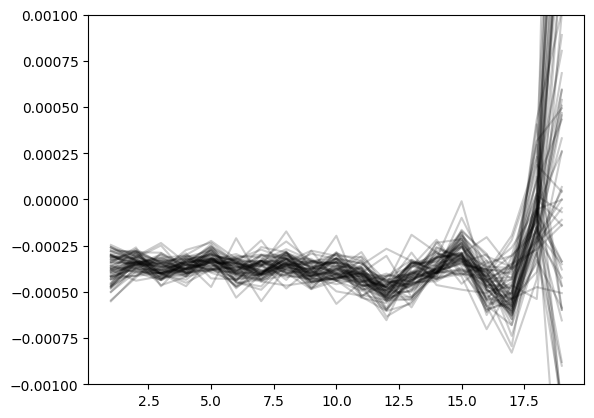

In [112]:
for ii in range(64):
    pl.plot(w_sp_samp.samples[ii,:], color='k',alpha=0.2)
    pl.ylim([-0.001,0.001])

# $NK - <K>$ for each jackknife sample

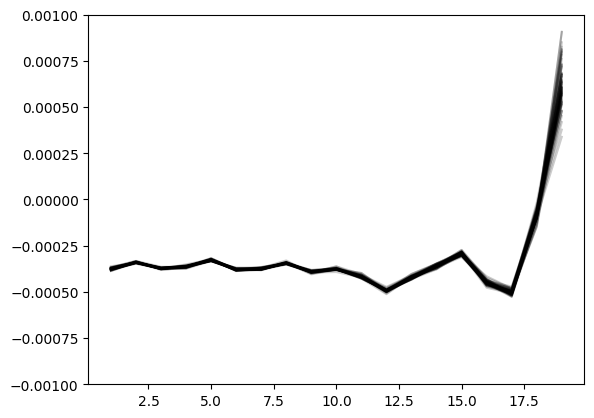

In [116]:
# now let's access nk samles:
for ii in range(64):
    pl.plot(w_sp_samp.samples[ii,:] - data_holder2[ii,:], color='k',alpha=0.2)
    pl.ylim([-0.001,0.001])

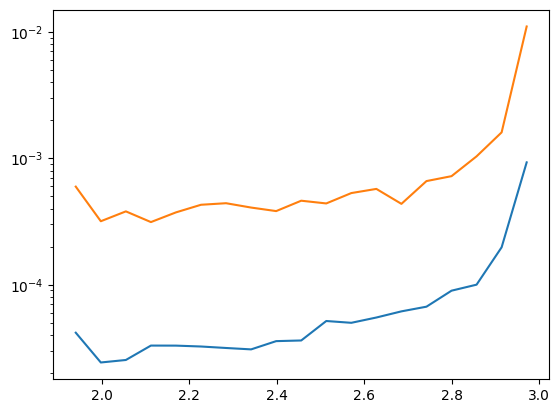

In [126]:
# now compute the error between jk samples:
njn=64
jk_samples = w_sp_samp.samples - data_holder2
error = np.std(jk_samples,axis=0)*np.sqrt(njn-1)
pl.plot(zsamp, error)
pl.plot(zsamp, w_sp_samp.error)
pl.yscale('log')

# $NK - RK$

Check the run with random: ~1.6 times photometric sample

In [131]:
folder = "test-njn-64-noscale-1-10-arcm-w-random/"
ncc = RedshiftData.from_files(root + folder + "nz_estimate")
#ncc.data, ncc.error
w_sp = yaw.correlation.corrfunc.CorrFunc_scalar.from_file(root + folder +  "w_sp.hdf5")
w_ss = yaw.correlation.corrfunc.CorrFunc_scalar.from_file(root + folder +  "w_ss.hdf5")

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:607: RuntimeWarning: invalid value encountered in divide
  data = counts.data / sum_weights.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:608: RuntimeWarning: invalid value encountered in divide
  samples = counts.samples / sum_weights.samples


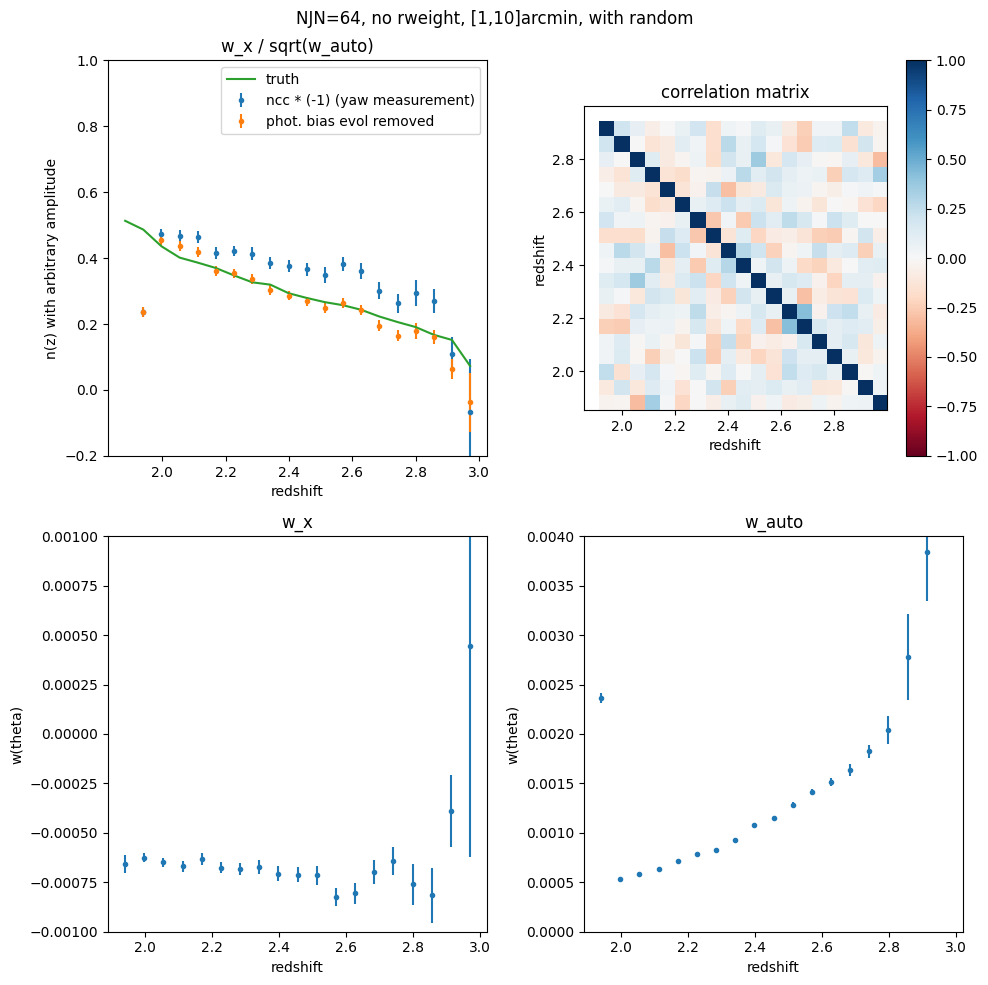

In [132]:
fig,axarr=pl.subplots(2,2, figsize=[10,10])
fig.suptitle("NJN=64, no rweight, [1,10]arcmin, with random")
x = ncc.binning.mids

pl.sca(axarr[0,0])
pl.errorbar(x, -ncc.data, yerr=ncc.error,fmt='.',label="ncc * (-1) (yaw measurement)")
pl.ylabel("n(z) with arbitrary amplitude")
pl.xlabel("redshift")
pl.title("w_x / sqrt(w_auto)")
pl.errorbar(x, -ncc.data/bias_z_int*bias_z_int[1], 
            yerr=ncc.error/bias_z_int*bias_z_int[1],fmt='.',label="phot. bias evol removed")
pl.ylim([-0.2,1.0])
factor=0.34
pl.plot(nz_true[:,0], nz_true[:,1]/np.sum(nz_true[:,1])/(nz_true[1,0]-nz_true[0,0])*factor,label="truth")
pl.legend()

pl.sca(axarr[0,1])
pl.imshow(ncc.correlation,vmax=1,vmin=-1,cmap='RdBu',extent=[edges[0],edges[-1], edges[0],edges[-1]])
pl.colorbar()
pl.xlabel("redshift")
pl.ylabel("redshift")
pl.title("correlation matrix")

pl.sca(axarr[1,0])
w_sp_samp = w_sp.sample()  # creates a CorrFunc object
pl.errorbar(x, w_sp_samp.data, yerr=w_sp_samp.error,fmt='.')
pl.ylabel("w(theta)")
pl.xlabel("redshift")
pl.title("w_x")
pl.ylim([-0.001,0.001])

pl.sca(axarr[1,1])
w_ss_samp = w_ss.sample()  # creates a CorrFunc object
pl.errorbar(x, w_ss_samp.data, yerr=w_ss_samp.error,fmt='.')
pl.ylabel("w(theta)")
pl.xlabel("redshift")
pl.title("w_auto")
pl.ylim([0,0.004])
pl.tight_layout()